<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/structure/moment_curvature/steel_w_sec_moment_curvature.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<div style="font-size: 0.8em; color: #555;">By Hossein Karagah</div>
<div style="font-size: 0.8em; color: #555;">© Copyright 2025 GNU GENERAL PUBLIC LICENSE.</div>
</div>

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../.."))
from assets.modules.materials import ACIConcrete, BilinearSteel
from assets.modules.steel import LongitudinalRebar, TransverseRebar
from assets.modules.shapes import *
from assets.modules.analysis import *
import assets.modules.concrete as concrete
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from matplotlib.patches import bbox_artist

## FIND STRAND PROFILE

Strand profile:
y = 0.2565x^2 + -2.2649x + 0.0000


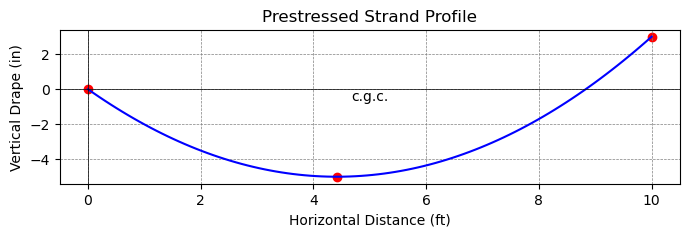

In [2]:
p0 = Point(0, 0)
p1 = Point(10, 3)
y_ext = -5

a, b, c = parabola_from_points(p0, p1, y_ext)

print(f"Strand profile:\ny = {a:.4f}x^2 + {b:.4f}x + {c:.4f}")

x_ext = -b / (2 * a)
y_ext_calc = a * x_ext**2 + b * x_ext + c

x_vals = np.linspace(min(p0.x, p1.x), max(p0.x, p1.x), 100)
y_vals = a * x_vals**2 + b * x_vals + c

plt.figure(figsize=(8, 2))
plt.plot(x_vals, y_vals, label='Parabolic Strand Profile', color='blue')
plt.scatter([p0.x, p1.x, x_ext], [p0.y, p1.y, y_ext_calc], color='red')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.text((p0.x + p1.x)/2, p0.y, "c.g.c.", fontsize=10, va='top', ha='center')
plt.xlabel('Horizontal Distance (ft)')
plt.ylabel('Vertical Drape (in)')
plt.title('Prestressed Strand Profile')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

## Define Beams, columns, and Joints

In [3]:
concrete = ACIConcrete(fc=5000, is_lightweight=False, density=150 / 12**3)

n_spans = 2

# Define lower and upper columns
lower_cols, upper_cols = [], []
for i in range(n_spans + 1):
    lower_cols.append(ConcreteColumn(length=11+4/12, width=24/12, depth=24/12, mat=concrete))
    upper_cols.append(ConcreteColumn(length=11+4/12, width=24/12, depth=24/12, mat=concrete))

# Define beams
beam_lengths = [62, 44]
beams: list[ConcreteTSectionBeam] = []
for length in beam_lengths:
    beams.append(ConcreteTSectionBeam(length=length, width=15/12, depth=36/12, flange_width=95/12, flange_thickness=5/12, mat=concrete))

# Define joints
joints = []
for i in range(n_spans + 1):
    left_beam = None if i == 0 else beams[i-1]
    right_beam = None if i == n_spans else beams[i]
    joints.append(Concrete2DJoint(left_beam, right_beam, lower_cols[i], upper_cols[i]))
    
print("Defined Columns:")
for col in lower_cols + upper_cols:
    print(col)
    
print("\nDefined Beams:")
for beam in beams:
    print(beam)
    
print("\nDefined Joints:")
for joint in joints:
    print(joint)


Defined Columns:
Column C1 @ J1 [height=11.33', 24.0" x 24.0"]
Column C3 @ J2 [height=11.33', 24.0" x 24.0"]
Column C5 @ J3 [height=11.33', 24.0" x 24.0"]
Column C2 @ J1 [height=11.33', 24.0" x 24.0"]
Column C4 @ J2 [height=11.33', 24.0" x 24.0"]
Column C6 @ J3 [height=11.33', 24.0" x 24.0"]

Defined Beams:
T-Beam B1 @ J1 --> J2 [length=62.00', web: 15.0" x 36.0", flange: 95.0" x 5.0"]
T-Beam B2 @ J2 --> J3 [length=44.00', web: 15.0" x 36.0", flange: 95.0" x 5.0"]

Defined Joints:
2D Joint J1 @ None← →B1, C1↓ ↑C2
2D Joint J2 @ B1← →B2, C3↓ ↑C4
2D Joint J3 @ B2← →None, C5↓ ↑C6


## Compute Beam Section Properties

Both spans have the same section.

In [5]:
# Beam section properties

# Beam area
A = beams[0].sec.area * 12**2 # ft^2
print(f"A={A:.0f} in^2")

# Beam moment of inertia
I = beams[0].sec.moment_inertia()[0] * 12**4 # in^4
print(f"I={I:.0f} in^4")

# Beam centroid relait veo the top and bottom and top of the beam
yt = beams[0].sec.yt * 12 # in
yb =  beams[0].sec.yb * 12 # in
print(f"yt={yt:.1f} in")
print(f"yb={yb:.1f} in")

# Beam section modulus
S_t = I / yt # in^3
S_b = I / yb # in^3
print(f"St={S_t:.0f} in^3")
print(f"Sb={S_b:.0f} in^3")

A=940 in^2
I=114360 in^4
yt=11.4 in
yb=24.6 in
St=10028 in^3
Sb=4650 in^3


## Define Loads

* Both spans have the same 15"x36" beam cast monolitically with the slab creating a T-section.
* Beams are repated @ 18-ft o.c.
* For the live load assume standard parking loading

In [6]:
# Compute area loads
concrete_density = concrete.density * (12**3/1e3) # k/ft^3

slab_thickness = 5/12 # ft
slab_load = slab_thickness *  concrete_density# k/ft^2

beam_spacing = 18 # ft
beam_sec: ConcreteTSectionBeam = beams[0]
beam_load = (beam_sec.depth - slab_thickness) * beam_sec.width * concrete_density / beam_spacing # k/ft^2

superimposed_dead_load = 2 / 1e3 # k/ft^2

concrete_load = slab_load + beam_load # k/ft^2
dead_load = concrete_load + superimposed_dead_load # k/ft^2
live_load = 40 / 1e3 # k/ft^2

print(f"Concrete load: {concrete_load:.3f} k/ft^2")
print(f"Dead load: {dead_load:.3f} k/ft^2")
print(f"Live load: {live_load:.3f} k/ft^2\n")

# Compute beam loads
w_conc = concrete_load * beam_spacing # k/ft
w_dead = dead_load * beam_spacing # k/ft
w_live = live_load * beam_spacing # k/ft

print(f"w_conc = {w_conc:.3f} k/ft")
print(f"w_dead = {w_dead:.3f} k/ft")
print(f"w_live = {w_live:.3f} k/ft\n")

# Compute factored loads
w_ud = 1.2 * w_dead # k/ft
w_ul = 1.6 * w_live # k/ft
w_u = w_ud + w_ul # k/ft

print(f"w_ud = {w_ud:.3f} k/ft")
print(f"w_ul = {w_ul:.3f} k/ft")
print(f"w_u = {w_u:.3f} k/ft\n")


Concrete load: 0.089 k/ft^2
Dead load: 0.091 k/ft^2
Live load: 0.040 k/ft^2

w_conc = 1.609 k/ft
w_dead = 1.645 k/ft
w_live = 0.720 k/ft

w_ud = 1.974 k/ft
w_ul = 1.152 k/ft
w_u = 3.126 k/ft



## Compute Prestressing Force

Balacing approximately 70% of concrete load in each span and proviing a minimum of 250 psi average prestressing compression.


In [26]:
min_comp_stress = 250 /1e3 # ksi
balance_factor = 0.7

# Beam: A-----B-----C
# Center of gravity of strand profile (c.g.s.) from the top of the beam
cgs_a = yt # in
cgs_ab = beam_sec.depth * 12 - 4 # in
cgs_b = 4 # in

# Compute prestressing force to balance 70% of concrete load
l_ab = beams[0].length # ft
ecc_ab = cgs_ab - (cgs_a + cgs_b) / 2 # in
w_eq_ab = balance_factor * w_conc
F_min = min_comp_stress * (beams[0].sec.area * 12**2) # kips
F = max(F_min, (w_eq_ab * l_ab**2 / 8) / (ecc_ab / 12)) # kips
print(f"a={ecc_ab:.1f} in")
print(f"F={F:.0f} kips ≥ Fmin={F_min:.0f} kips\n")

a=24.3 in
F=267 kips ≥ Fmin=235 kips



## Compute Number of Strands

* Assume 1/2"-strands with the area of 0.153 in² and $f_{pu}=270\ ksi$.
* Assume $15\ ksi$ prestressing loss.

In [8]:
strand_area = 0.153 # in^2
fpu = 270 # ksi
prestressing_loss = 15 # ksi
fpe = 0.7 * fpu - prestressing_loss # ksi

# Compute number of required strands
n_strands = F / (strand_area * fpe)
n_strands = int(np.floor(n_strands))
Aps = n_strands * strand_area # in^2
F = n_strands * strand_area * fpe # kips
print(f"Number of 1/2\"-strands: {n_strands} (Aps={Aps:.3f} in^2)")
print(f"Provided prestressing force: F={F:.0f} kips")


Number of 1/2"-strands: 10 (Aps=1.530 in^2)
Provided prestressing force: F=266 kips


## Compute Drape in Shorter Span

Using the prestressing force and number of strands determined in the previous section, I calculate the drape in the middle of the second span to balance 70% of the concrete load.

In [27]:
# Beam: A-----B-----C
l_bc = beams[1].length # ft
ecc_bc = (w_eq_ab * l_bc**2 / 8) / F * 12 # in
cgs_c = yt  # in
cgs_bc = ecc_bc + (cgs_b + cgs_c) / 2 # in
print(f"a={beams[0].depth * 12 - cgs_bc:.1f} in (from the bottom of the beam)")

a=16.1 in (from the bottom of the beam)


## Determine Actual Prestressing Equivalent Loads

In [48]:
w_eq_ab = 8 * F * (ecc_ab / 12) / (l_ab**2) # k/ft
w_eq_bc = 8 * F * (ecc_bc / 12) / (l_bc**2) # k/ft

print(f"{'Span':<7}{'w_eq (klf)':<16}{'a (in)':<10}{'mid-span drape (in)':<15}")
print(f"{'-'*7:<7}{'-'*15:<15}{'-'*15:<15}{'-'*15:<15}")
print(f"{'AB':<7}{w_eq_ab:.3f} ({100*w_eq_ab/w_conc:.1f}{'%)':<5}{ecc_ab:<10.3f}{beams[0].depth * 12 - cgs_ab:<15.3f}")
print(f"{'BC':<7}{w_eq_bc:.3f} ({100*w_eq_bc/w_conc:.1f}{'%)':<5}{ecc_bc:<10.3f}{beams[1].depth * 12 - cgs_bc:<15.3f}")

Span   w_eq (klf)      a (in)    mid-span drape (in)
----------------------------------------------------
AB     1.127 (70.0%)   24.298    4.000          
BC     1.127 (70.0%)   12.237    16.060         


## Compute Distribution Factors, Carry-Over Factors, and Fixed-End Moments

In [ ]:
import pandas as pd

# Build DataFrame with joint + element association
df = pd.DataFrame({
    "Joint ID": [j.id for j in joints for e in j._elements],
    "Element ID": [e.id for j in joints for e in j._elements],
    "Stiffness": [j.stiffness_factors[e.id] for j in joints for e in j._elements],
    "Distribution": [j.distribution_factors[e.id] for j in joints for e in j._elements],
    "Carry-Over": [j.carry_over_factors[e.id] for j in joints for e in j._elements]
})

# Group by Joint ID
grouped = df.groupby("Joint ID")

for joint_id, group in grouped:
    print(f"\nJoint {joint_id}")
    print(group)


# grouped_df = grouped.apply(lambda g: g).drop("Joint ID", axis=1)



Joint J1
  Joint ID Element ID      Stiffness  Distribution  Carry-Over
0       J1         B1  224239.964792      0.189091    0.524187
1       J1         C2  480820.475546      0.405454    0.477149
2       J1         C1  480820.475546      0.405454    0.477149

Joint J2
  Joint ID Element ID      Stiffness  Distribution  Carry-Over
3       J2         B1  224239.964792      0.148207    0.524187
4       J2         B2  327139.638317      0.216216    0.534073
5       J2         C4  480820.475546      0.317788    0.477149
6       J2         C3  480820.475546      0.317788    0.477149

Joint J3
  Joint ID Element ID      Stiffness  Distribution  Carry-Over
7       J3         B2  327139.638317      0.253837    0.534073
8       J3         C6  480820.475546      0.373082    0.477149
9       J3         C5  480820.475546      0.373082    0.477149
